This is my first time participating in a contest. I am just doing some beginner exploratory data analysis, preprocessing and used a Standard Neural Network following the guidelines of [this notebook.](https://www.kaggle.com/code/kendontcare11/public-classifier-cat-xgb-lb-0-688/notebook) Thanks!

# Importing Libraries

In [1]:
!pip install -q /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install -q /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl
!pip install -q /kaggle/input/cibmtr-pip-install-pycox

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
ERROR: Directory '/kaggle/input/cibmtr-pip-install-pycox' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV, cross_validate, KFold
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# Pipeline
from sklearn.pipeline import Pipeline

# Explainable AI
import shap

# Data Loading and Understanding

In [4]:
# Load datatrain
data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
data.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [5]:
# Load dataset
test_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
test_data.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3 non-null      int64  
 1   dri_score               3 non-null      object 
 2   psych_disturb           3 non-null      object 
 3   cyto_score              1 non-null      object 
 4   diabetes                3 non-null      object 
 5   hla_match_c_high        2 non-null      float64
 6   hla_high_res_8          2 non-null      float64
 7   tbi_status              3 non-null      object 
 8   arrhythmia              3 non-null      object 
 9   hla_low_res_6           3 non-null      float64
 10  graft_type              3 non-null      object 
 11  vent_hist               3 non-null      object 
 12  renal_issue             3 non-null      object 
 13  pulm_severe             3 non-null      object 
 14  prim_disease_hct        3 non-null      object

In [8]:
print(data.shape)
print(list(data.columns))
print(list(data.dtypes))

(28800, 60)
['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'efs', 'efs_time']
[dtype('int64'), dtype('O'

In [9]:
print(test_data.shape)
print(list(test_data.columns))
print(list(test_data.dtypes))

(3, 58)
['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']
[dtype('int64'), dtype('O'), dtype('O'), dtype('O

# Data Cleaning

## Data Visualization with Target

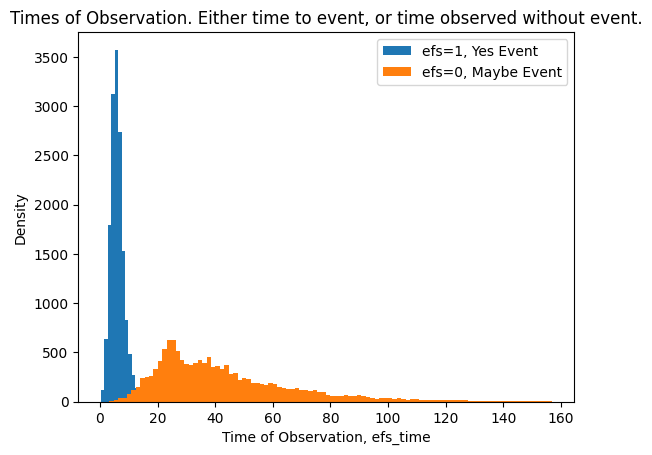

In [10]:
plt.hist(data.loc[data.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(data.loc[data.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

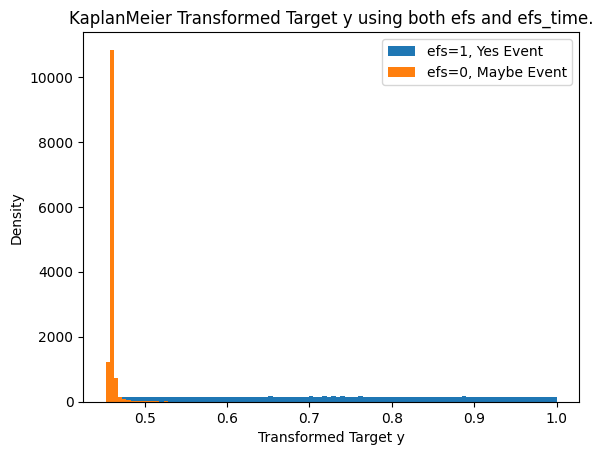

In [11]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
    
data["y"] = transform_survival_probability(data, time_col='efs_time', event_col='efs')

plt.hist(data.loc[data.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(data.loc[data.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

## Low Impact Feature Drop

I have analyzed the feature importance with SHAP and using XGB model before. Here is the plot:

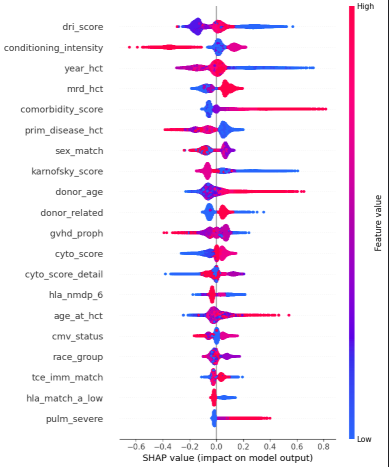


From the plot I am removing some features as they have low importance.

In [12]:
RMV = ["ID","efs","efs_time", 'y']
FEATURES = [c for c in data.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [13]:
LOW_IMPACT_FEATURES = ["sex_match", "gvhd_proph", "cmv_status", 
                       "tce_imm_match", "pulm_severe"]

FEATURES = [feat for feat in FEATURES if feat not in LOW_IMPACT_FEATURES]


In [14]:
CATS = []
for c in FEATURES:
    if data[c].dtype=="object":
        CATS.append(c)

## Duplicate Data Handling

In [15]:
# Drop Duplicate Rows
data = data.drop_duplicates()
data.shape

(28800, 61)

There are no duplicate rows

In [16]:
print(data.dtypes.value_counts())

object     35
float64    24
int64       2
Name: count, dtype: int64


In [17]:
print(test_data.dtypes.value_counts())

object     35
float64    21
int64       2
Name: count, dtype: int64


## Exploratory Data Analysis

### Missing Value Analysis

10.790926684881603


<Axes: >

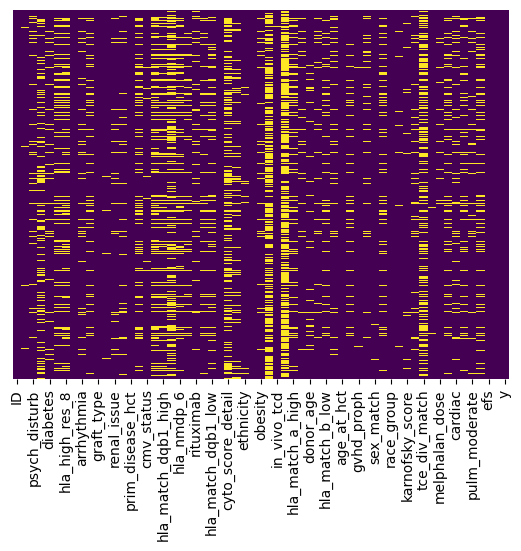

In [18]:
# how many total missing values do we have?
missing_values = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values.sum()
test_data
# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

9.770114942528735


<Axes: >

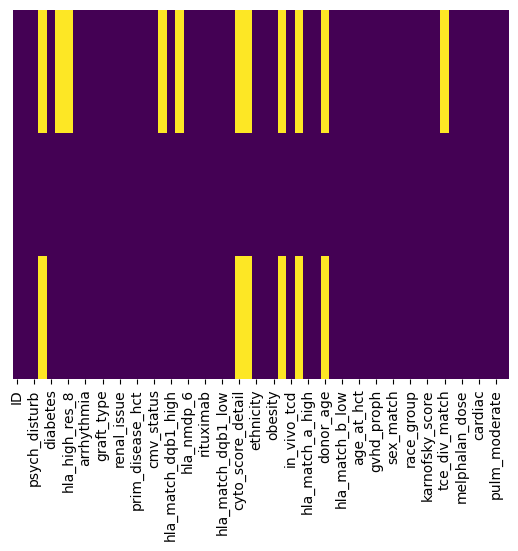

In [19]:
# how many total missing values do we have?
missing_values = test_data.isnull().sum()
total_cells = np.product(test_data.shape)
total_missing = missing_values.sum()

# percent of test_data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

sns.heatmap(test_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Univariate Analysis
#### Integer Columns

In [20]:
# Separate integer columns
int_cols = data.select_dtypes(include=['int']).columns.tolist()

# Separate float columns
float_cols = data.select_dtypes(include=['float']).columns.tolist()

# Separate categorical columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

print("Integer columns:", int_cols)
print("Float columns:", float_cols)
print("Categorical columns:", cat_cols)

Integer columns: ['ID', 'year_hct']
Float columns: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'efs', 'efs_time', 'y']
Categorical columns: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardi

Column: ID
Summary Statistics:
count    28800.000000
mean     14399.500000
std       8313.988213
min          0.000000
25%       7199.750000
50%      14399.500000
75%      21599.250000
max      28799.000000
Name: ID, dtype: float64


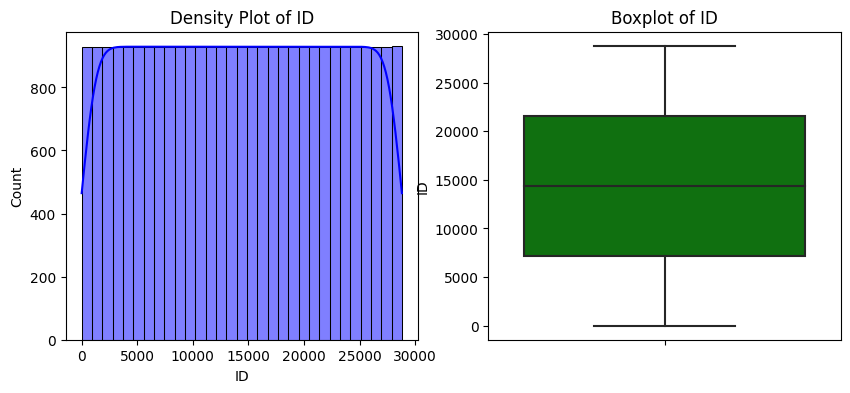

Column: year_hct
Summary Statistics:
count    28800.000000
mean      2015.179444
std          3.153914
min       2008.000000
25%       2013.000000
50%       2016.000000
75%       2018.000000
max       2020.000000
Name: year_hct, dtype: float64


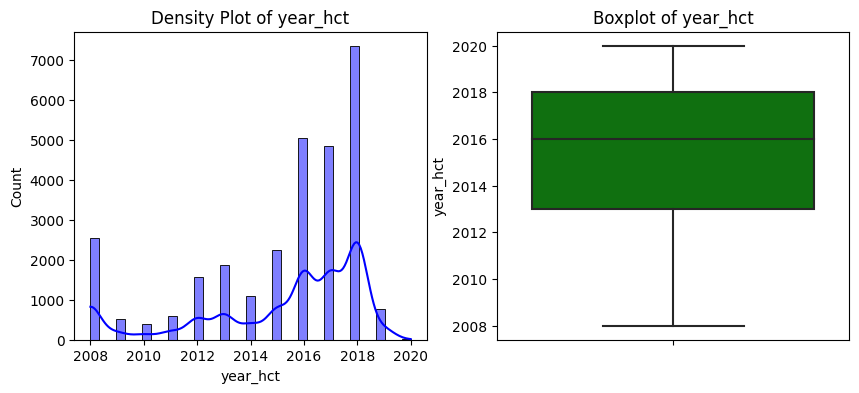

In [21]:
# Plot density plot and histogram for integer columns
for col in int_cols:
    print("Column:", col)
    print("Summary Statistics:")
    print(data[col].describe())
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, color='blue')
    plt.title(f'Density Plot of {col}')
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data[col], color='green')
    plt.title(f'Boxplot of {col}')
    plt.show()

#### Float Columns

Column: hla_match_c_high
Summary Statistics:
count    24180.000000
mean         1.764516
std          0.431941
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_c_high, dtype: float64


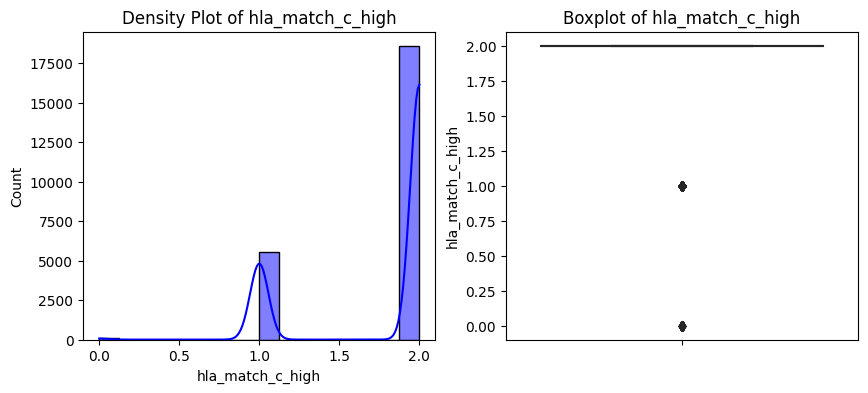

Column: hla_high_res_8
Summary Statistics:
count    22971.000000
mean         6.876801
std          1.564313
min          2.000000
25%          6.000000
50%          8.000000
75%          8.000000
max          8.000000
Name: hla_high_res_8, dtype: float64


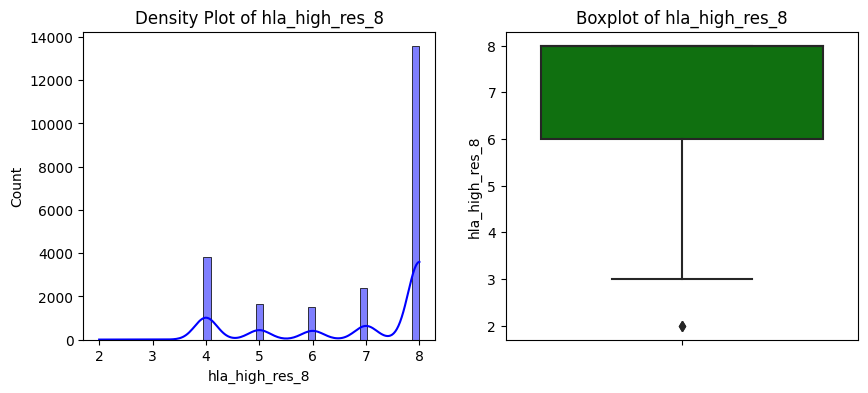

Column: hla_low_res_6
Summary Statistics:
count    25530.000000
mean         5.143322
std          1.207757
min          2.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          6.000000
Name: hla_low_res_6, dtype: float64


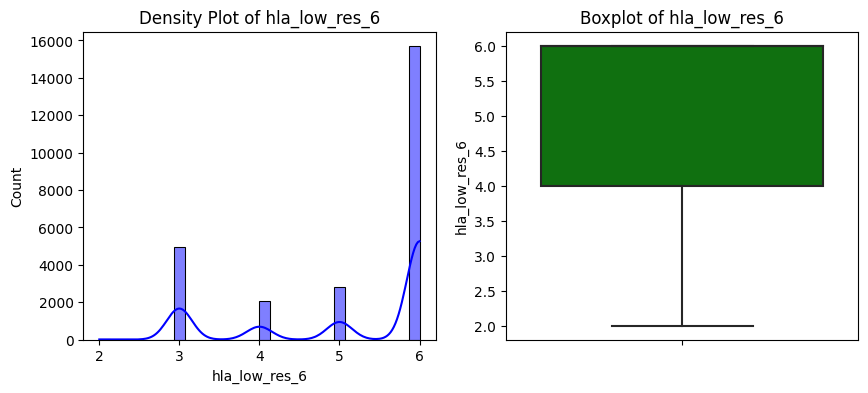

Column: hla_high_res_6
Summary Statistics:
count    23516.000000
mean         5.109202
std          1.214162
min          0.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          6.000000
Name: hla_high_res_6, dtype: float64


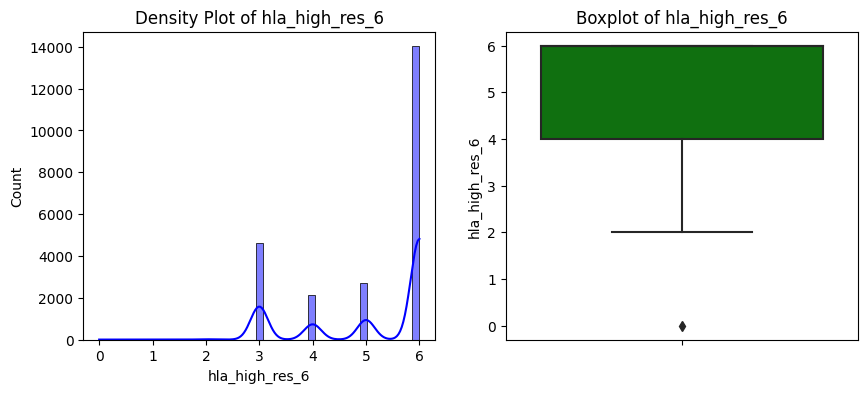

Column: hla_high_res_10
Summary Statistics:
count    21637.000000
mean         8.617230
std          1.905125
min          3.000000
25%          7.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: hla_high_res_10, dtype: float64


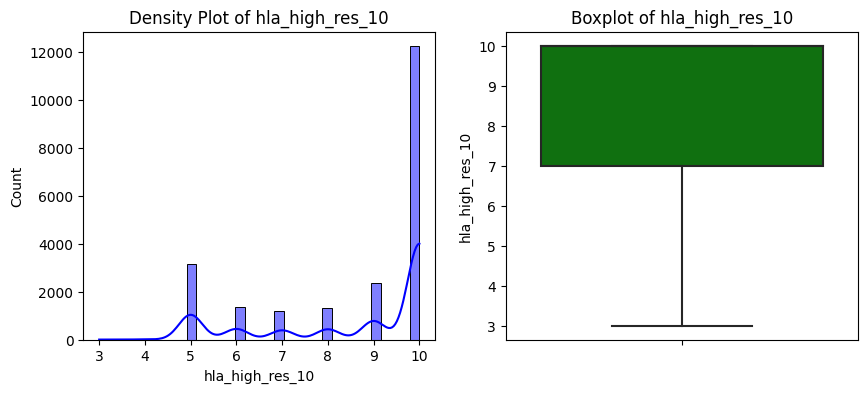

Column: hla_match_dqb1_high
Summary Statistics:
count    23601.000000
mean         1.736876
std          0.447687
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_dqb1_high, dtype: float64


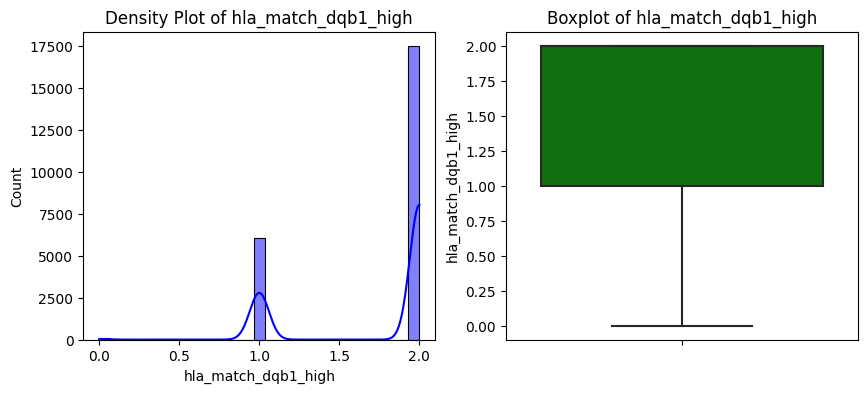

Column: hla_nmdp_6
Summary Statistics:
count    24603.000000
mean         5.160346
std          1.203240
min          2.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          6.000000
Name: hla_nmdp_6, dtype: float64


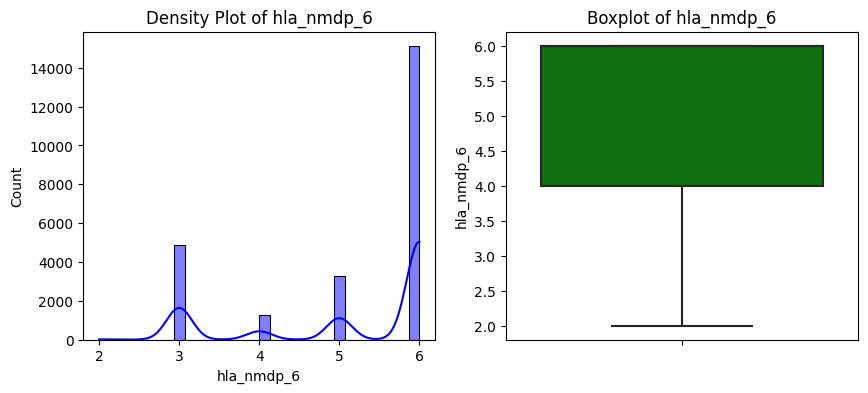

Column: hla_match_c_low
Summary Statistics:
count    26000.000000
mean         1.757808
std          0.435453
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_c_low, dtype: float64


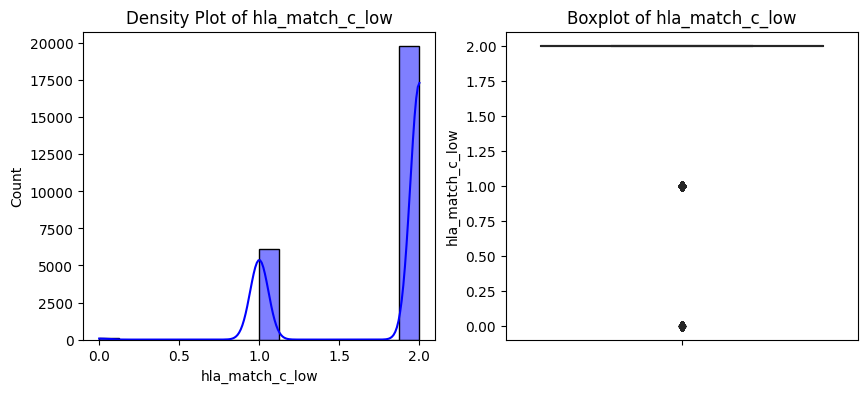

Column: hla_match_drb1_low
Summary Statistics:
count    26157.000000
mean         1.715296
std          0.451282
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_drb1_low, dtype: float64


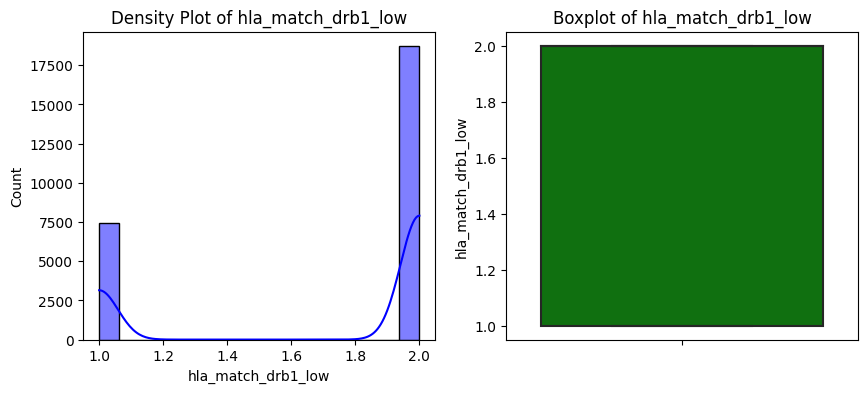

Column: hla_match_dqb1_low
Summary Statistics:
count    24606.000000
mean         1.773795
std          0.427130
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_dqb1_low, dtype: float64


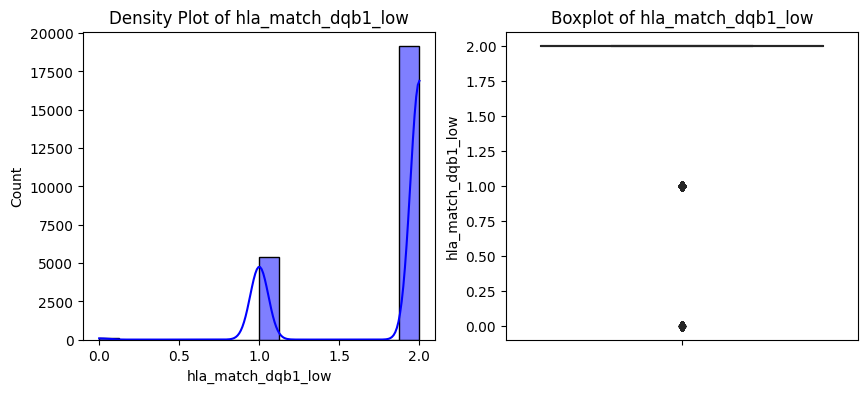

Column: hla_match_a_high
Summary Statistics:
count    24499.000000
mean         1.703743
std          0.462213
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_a_high, dtype: float64


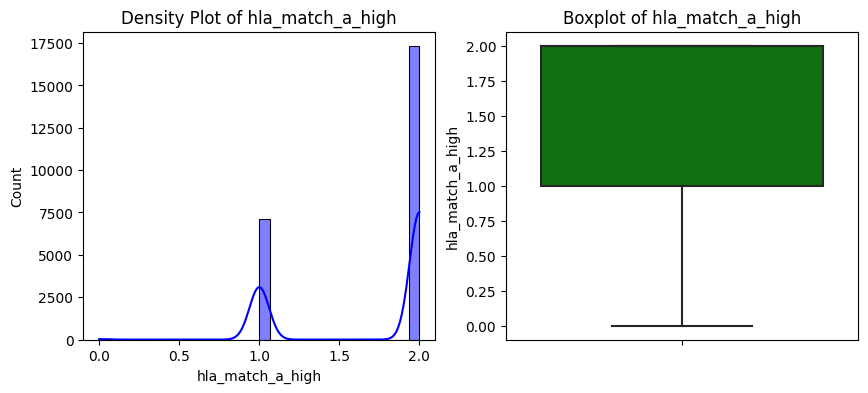

Column: donor_age
Summary Statistics:
count    26992.000000
mean        42.511591
std         15.251434
min         18.010000
25%         28.447000
50%         40.063000
75%         56.131500
max         84.800000
Name: donor_age, dtype: float64


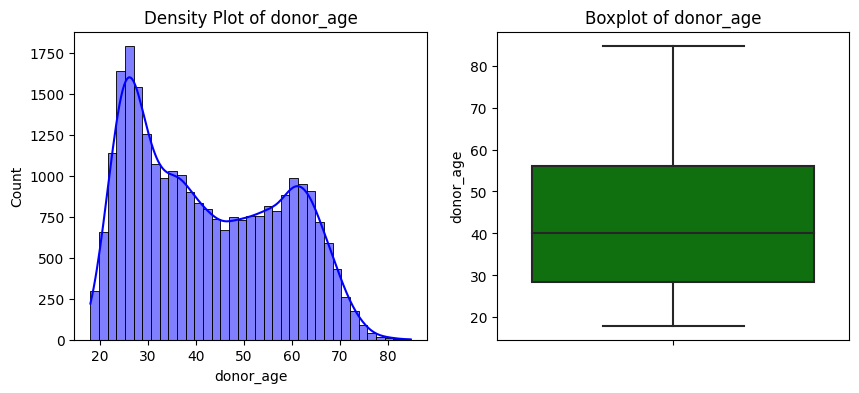

Column: hla_match_b_low
Summary Statistics:
count    26235.000000
mean         1.719916
std          0.454449
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_b_low, dtype: float64


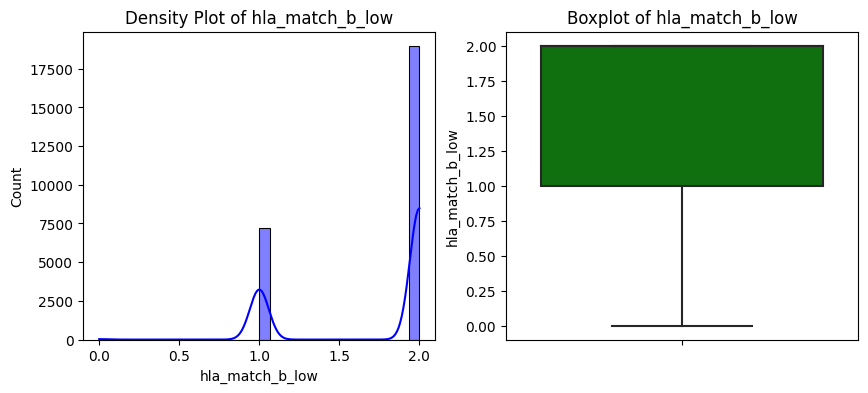

Column: age_at_hct
Summary Statistics:
count    28800.000000
mean        38.663162
std         21.147581
min          0.044000
25%         19.539000
50%         41.006000
75%         55.965250
max         73.726000
Name: age_at_hct, dtype: float64


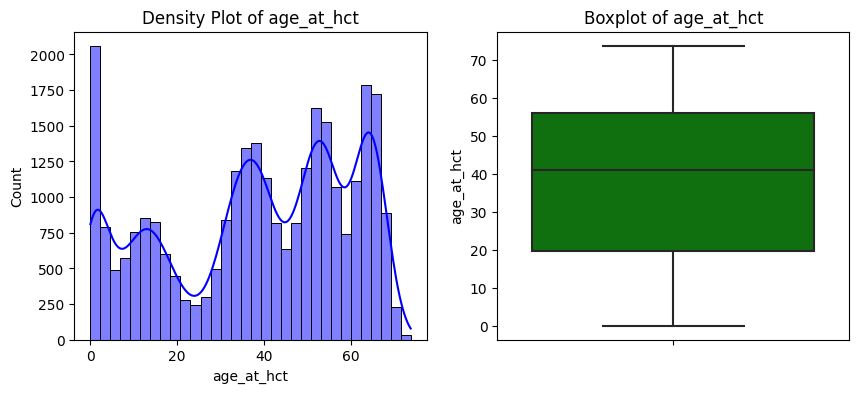

Column: hla_match_a_low
Summary Statistics:
count    26410.000000
mean         1.709087
std          0.458259
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_a_low, dtype: float64


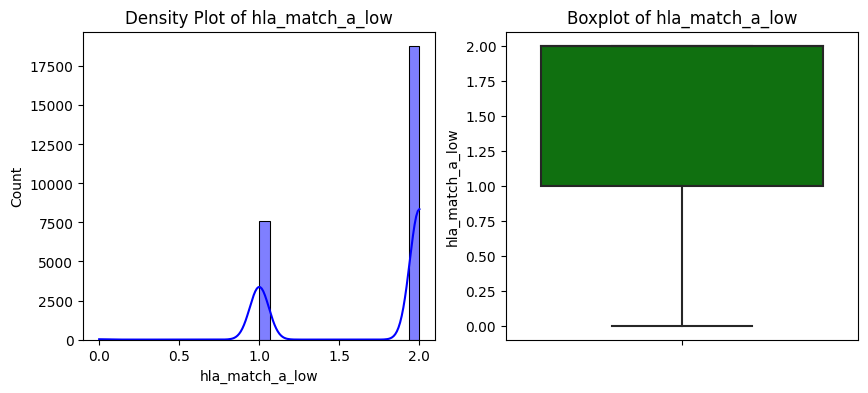

Column: hla_match_b_high
Summary Statistics:
count    24712.00000
mean         1.69962
std          0.46518
min          0.00000
25%          1.00000
50%          2.00000
75%          2.00000
max          2.00000
Name: hla_match_b_high, dtype: float64


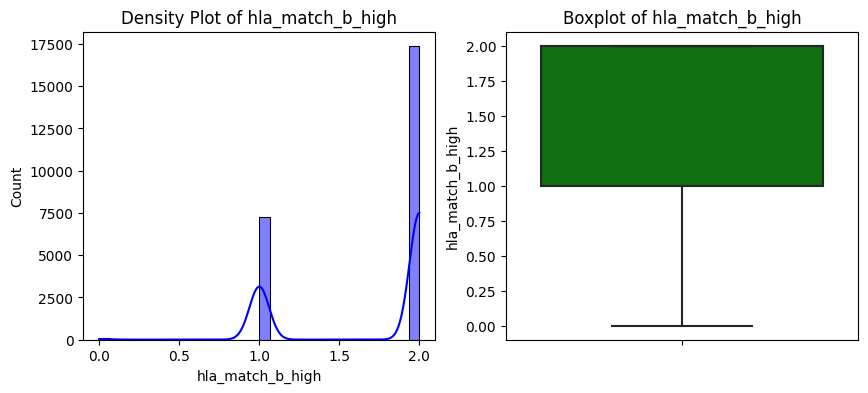

Column: comorbidity_score
Summary Statistics:
count    28323.000000
mean         1.702327
std          1.994443
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: comorbidity_score, dtype: float64


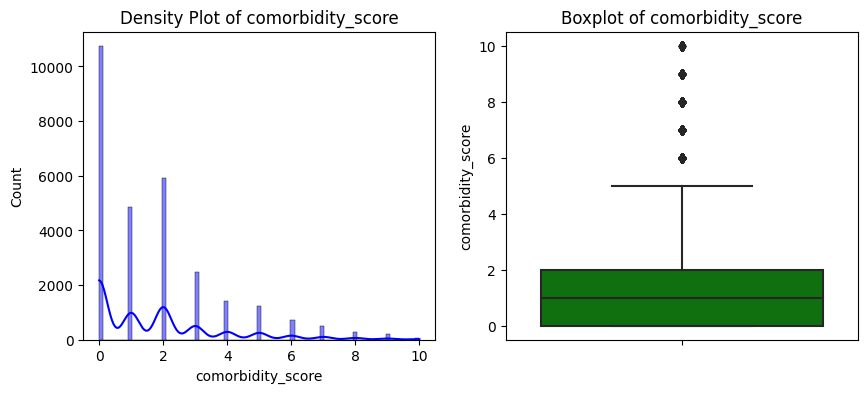

Column: karnofsky_score
Summary Statistics:
count    27930.00000
mean        83.83208
std         11.02884
min         40.00000
25%         70.00000
50%         90.00000
75%         90.00000
max        100.00000
Name: karnofsky_score, dtype: float64


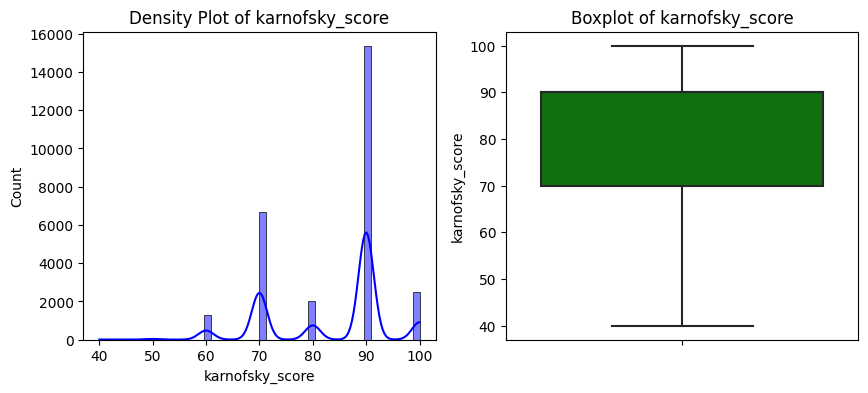

Column: hla_low_res_8
Summary Statistics:
count    25147.000000
mean         6.903448
std          1.565017
min          2.000000
25%          6.000000
50%          8.000000
75%          8.000000
max          8.000000
Name: hla_low_res_8, dtype: float64


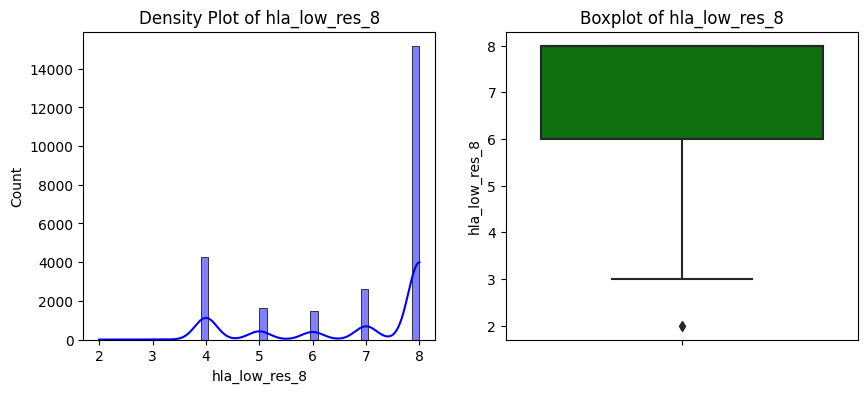

Column: hla_match_drb1_high
Summary Statistics:
count    25448.000000
mean         1.707128
std          0.461179
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: hla_match_drb1_high, dtype: float64


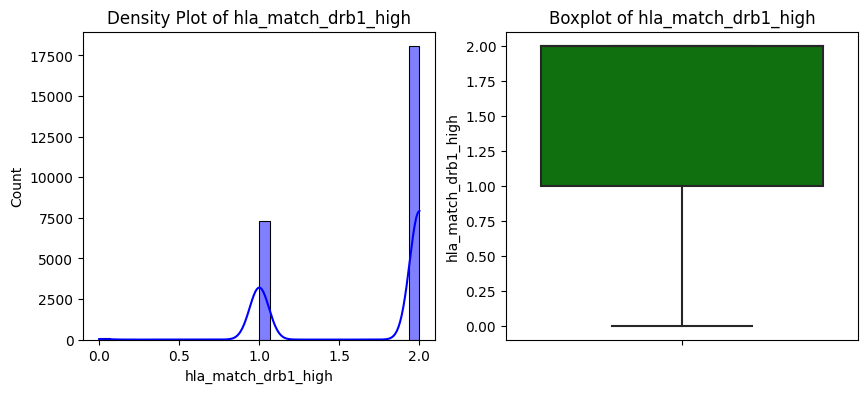

Column: hla_low_res_10
Summary Statistics:
count    23736.000000
mean         8.664687
std          1.882746
min          4.000000
25%          7.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: hla_low_res_10, dtype: float64


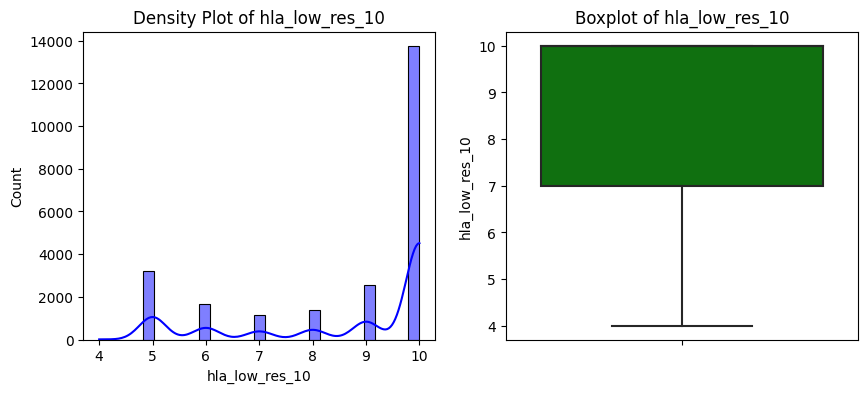

Column: efs
Summary Statistics:
count    28800.000000
mean         0.539306
std          0.498461
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: efs, dtype: float64


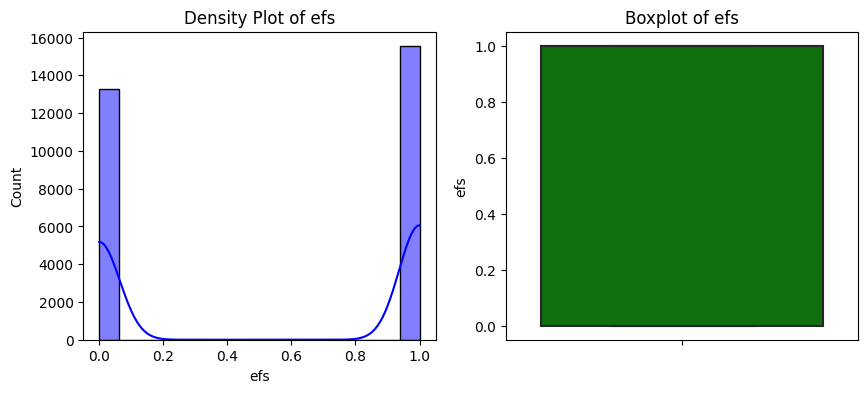

Column: efs_time
Summary Statistics:
count    28800.000000
mean        23.237678
std         24.799748
min          0.333000
25%          5.619750
50%          9.796500
75%         35.100000
max        156.819000
Name: efs_time, dtype: float64


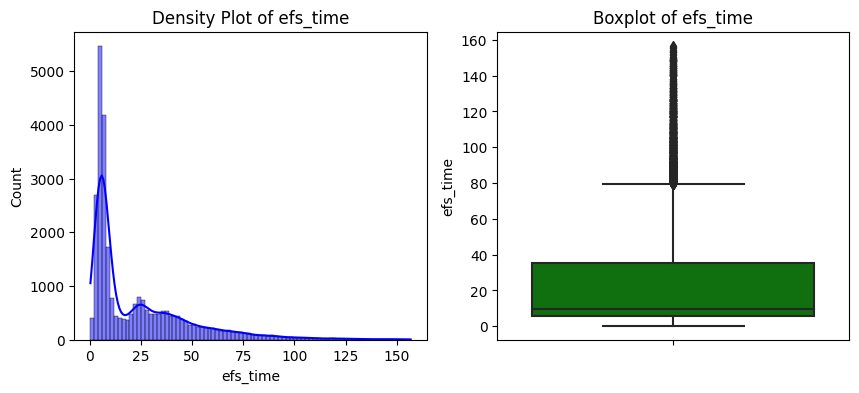

Column: y
Summary Statistics:
count    28800.000000
mean         0.606189
std          0.176714
min          0.452727
25%          0.459063
50%          0.503470
75%          0.750232
max          0.999965
Name: y, dtype: float64


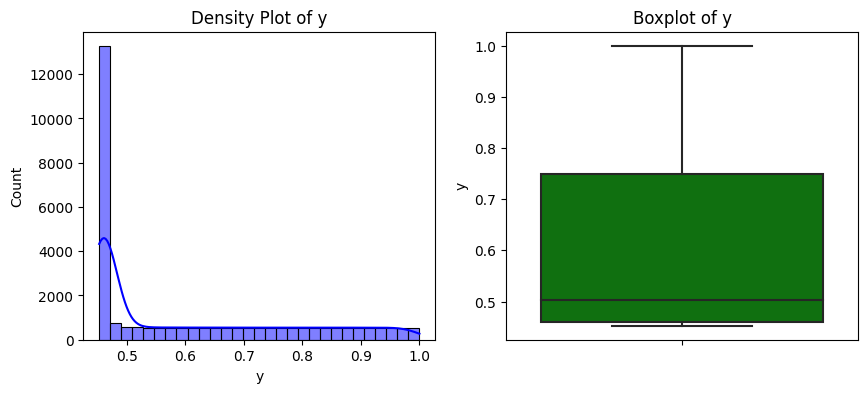

In [22]:
for col in float_cols:
    print("Column:", col)
    print("Summary Statistics:")
    print(data[col].describe())
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, color='blue')
    plt.title(f'Density Plot of {col}')
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data[col], color='green')
    plt.title(f'Boxplot of {col}')
    plt.show()

#### Categorical Columns

Column: dri_score
Value Counts:
dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing disease status                                   9
Name: count, dtype: int64
Bar plot:


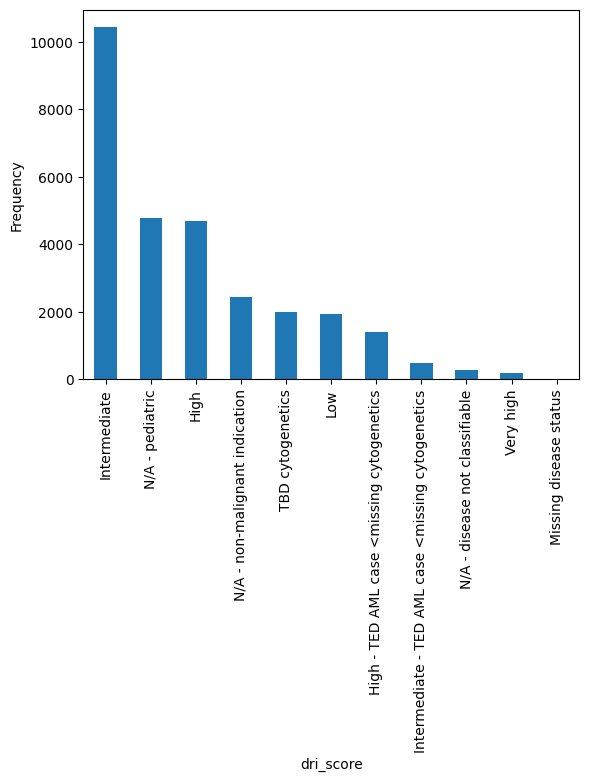

Column: psych_disturb
Value Counts:
psych_disturb
No          23005
Yes          3587
Not done      146
Name: count, dtype: int64
Bar plot:


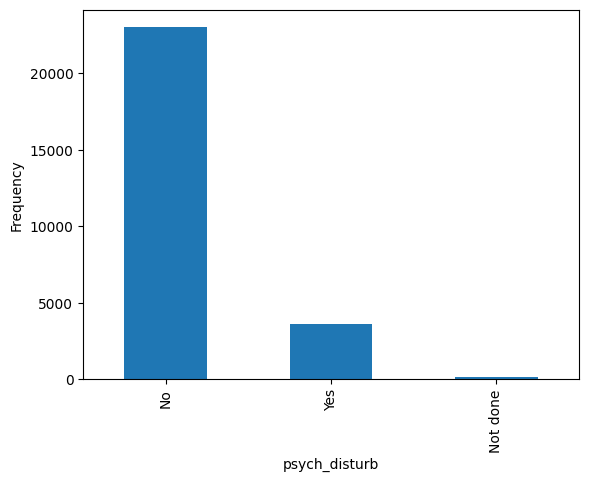

Column: cyto_score
Value Counts:
cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
Name: count, dtype: int64
Bar plot:


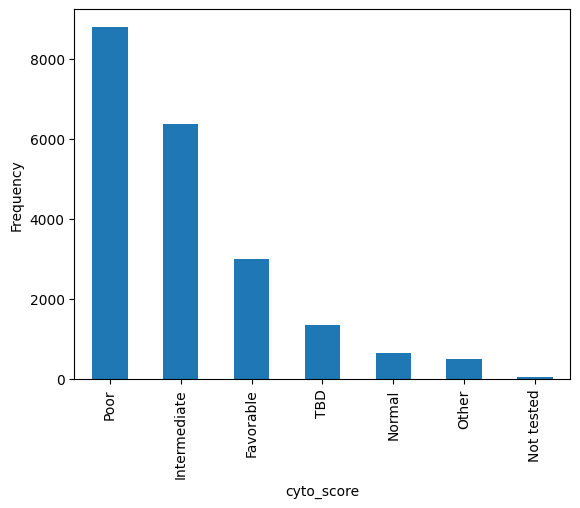

Column: diabetes
Value Counts:
diabetes
No          22201
Yes          4339
Not done      141
Name: count, dtype: int64
Bar plot:


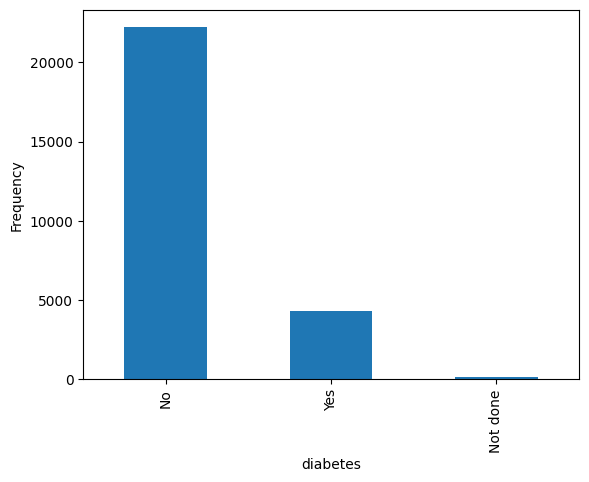

Column: tbi_status
Value Counts:
tbi_status
No TBI                              18861
TBI + Cy +- Other                    6104
TBI +- Other, <=cGy                  1727
TBI +- Other, >cGy                   1700
TBI +- Other, -cGy, single            134
TBI +- Other, -cGy, fractionated      119
TBI +- Other, -cGy, unknown dose       79
TBI +- Other, unknown dose             76
Name: count, dtype: int64
Bar plot:


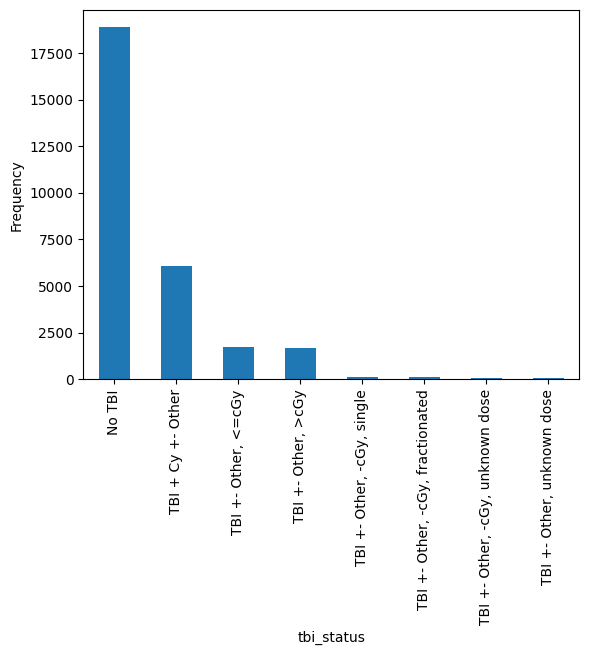

Column: arrhythmia
Value Counts:
arrhythmia
No          25203
Yes          1277
Not done      118
Name: count, dtype: int64
Bar plot:


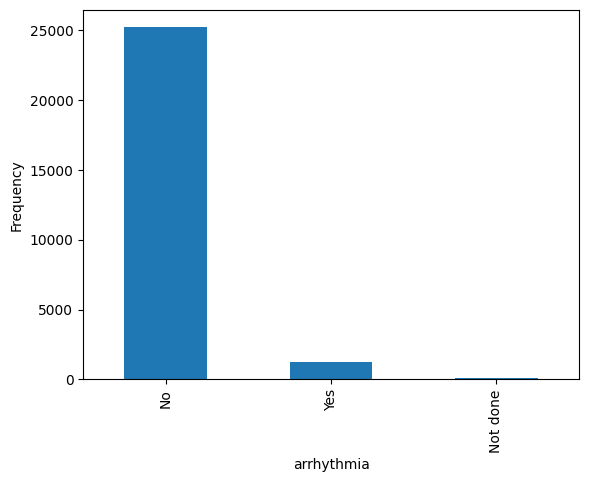

Column: graft_type
Value Counts:
graft_type
Peripheral blood    20546
Bone marrow          8254
Name: count, dtype: int64
Bar plot:


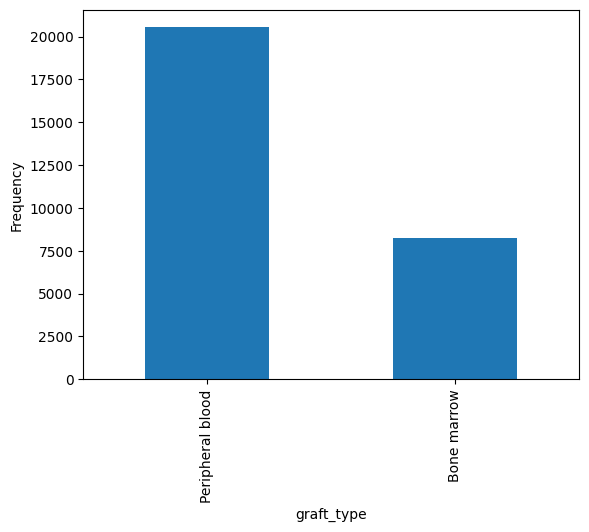

Column: vent_hist
Value Counts:
vent_hist
No     27721
Yes      820
Name: count, dtype: int64
Bar plot:


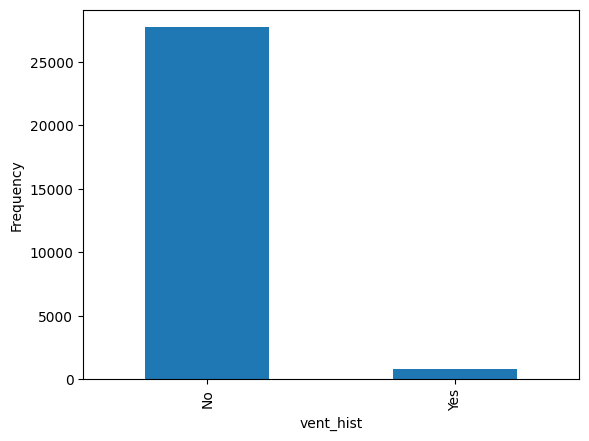

Column: renal_issue
Value Counts:
renal_issue
No          26548
Yes           200
Not done      137
Name: count, dtype: int64
Bar plot:


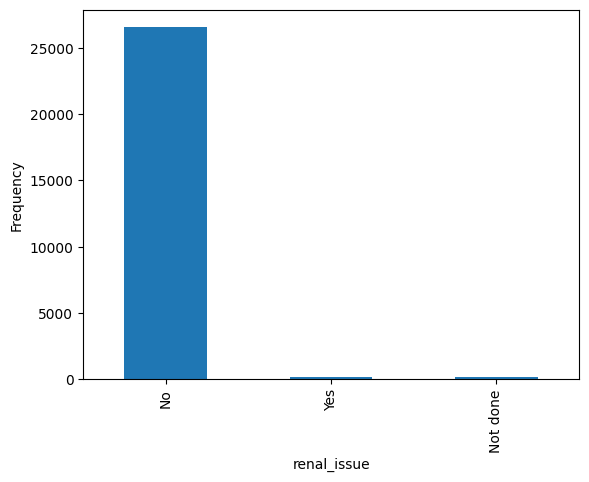

Column: pulm_severe
Value Counts:
pulm_severe
No          24779
Yes          1706
Not done      180
Name: count, dtype: int64
Bar plot:


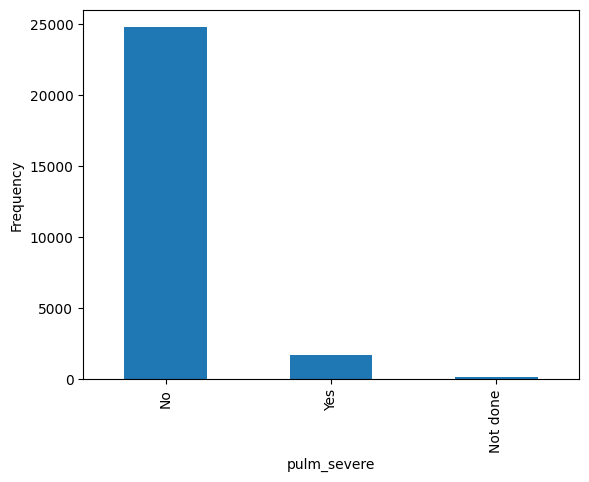

Column: prim_disease_hct
Value Counts:
prim_disease_hct
ALL                     8102
AML                     7135
MDS                     3046
IPA                     1719
MPN                     1656
IEA                     1449
NHL                     1319
IIS                     1024
PCD                      869
SAA                      713
AI                       449
HIS                      445
Other leukemia           366
Solid tumor              207
IMD                      144
Other acute leukemia      83
HD                        54
CML                       20
Name: count, dtype: int64
Bar plot:


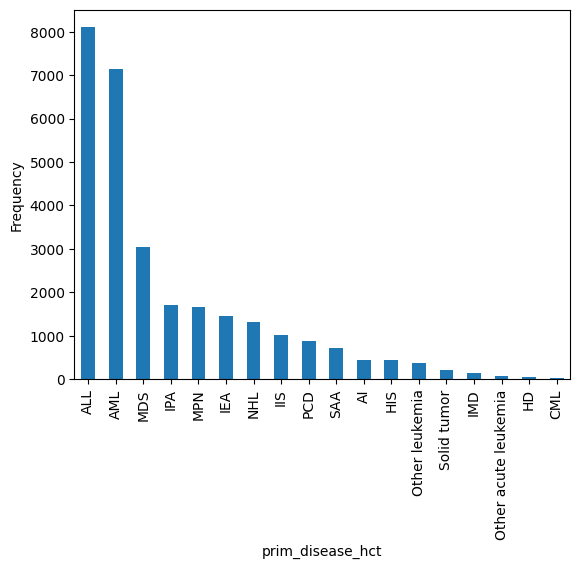

Column: cmv_status
Value Counts:
cmv_status
+/+    13596
-/+     7081
+/-     4048
-/-     3441
Name: count, dtype: int64
Bar plot:


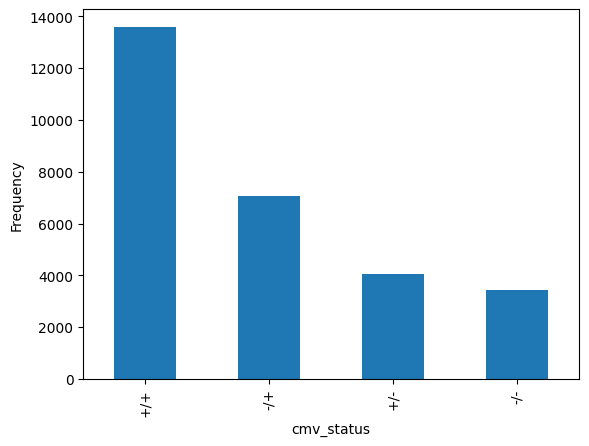

Column: tce_imm_match
Value Counts:
tce_imm_match
P/P    13114
G/G     2522
H/H     1084
G/B      544
H/B      229
P/H       83
P/B       66
P/G       25
Name: count, dtype: int64
Bar plot:


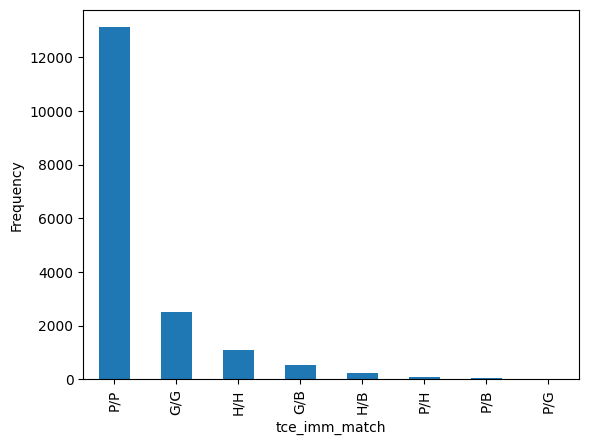

Column: rituximab
Value Counts:
rituximab
No     26033
Yes      619
Name: count, dtype: int64
Bar plot:


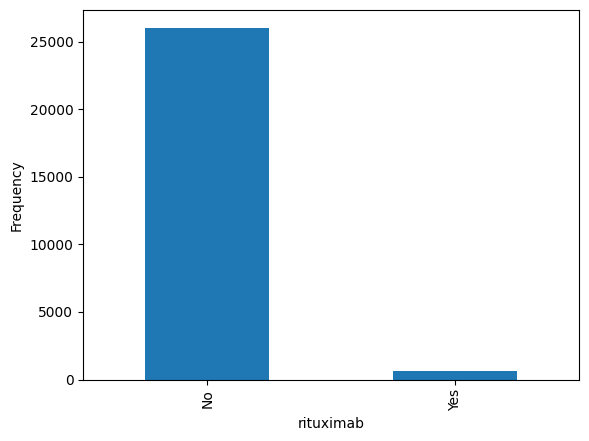

Column: prod_type
Value Counts:
prod_type
PB    20381
BM     8419
Name: count, dtype: int64
Bar plot:


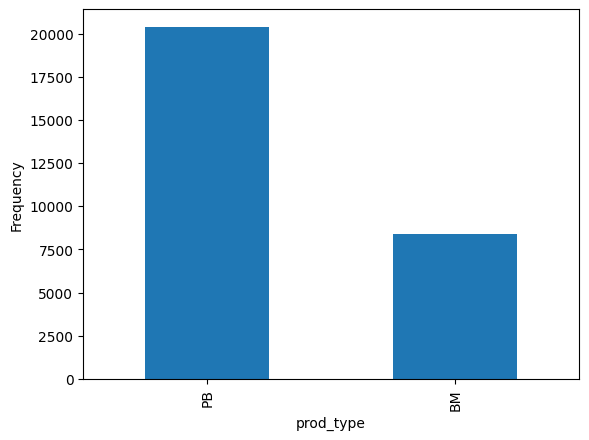

Column: cyto_score_detail
Value Counts:
cyto_score_detail
Intermediate    11158
Poor             3323
Favorable        1208
TBD              1043
Not tested        145
Name: count, dtype: int64
Bar plot:


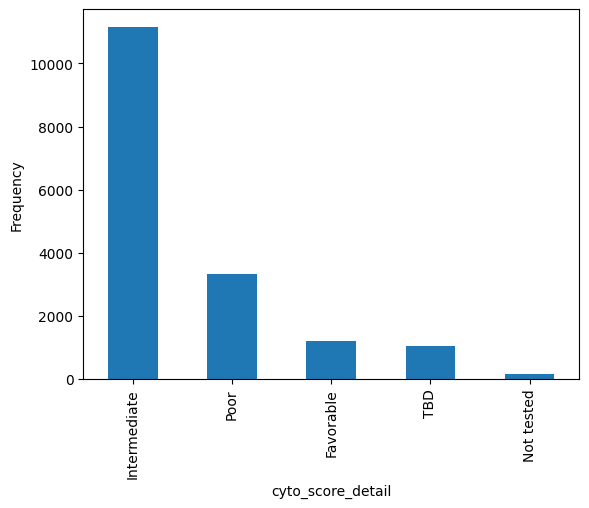

Column: conditioning_intensity
Value Counts:
conditioning_intensity
MAC                              12288
RIC                               7722
NMA                               3479
TBD                                373
No drugs reported                   87
N/A, F(pre-TED) not submitted       62
Name: count, dtype: int64
Bar plot:


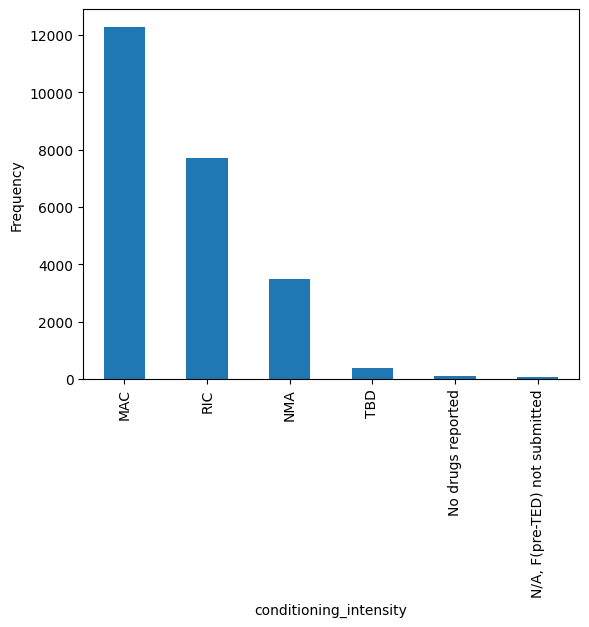

Column: ethnicity
Value Counts:
ethnicity
Not Hispanic or Latino      24482
Hispanic or Latino           3347
Non-resident of the U.S.      384
Name: count, dtype: int64
Bar plot:


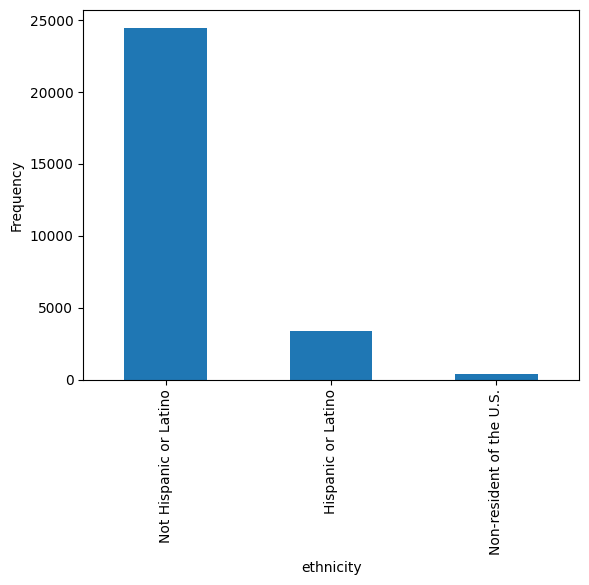

Column: obesity
Value Counts:
obesity
No          25144
Yes          1779
Not done      117
Name: count, dtype: int64
Bar plot:


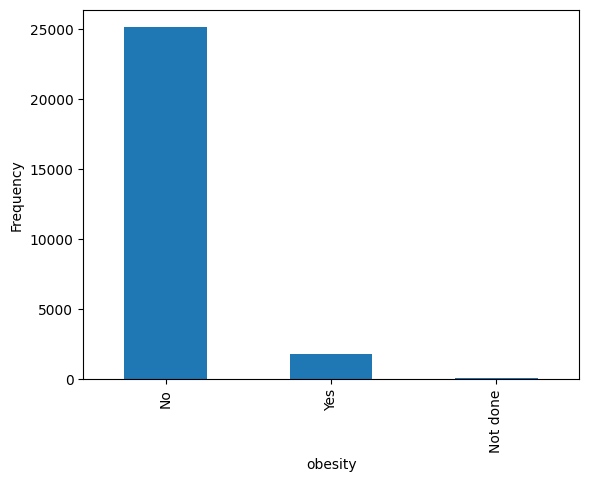

Column: mrd_hct
Value Counts:
mrd_hct
Negative    8068
Positive    4135
Name: count, dtype: int64
Bar plot:


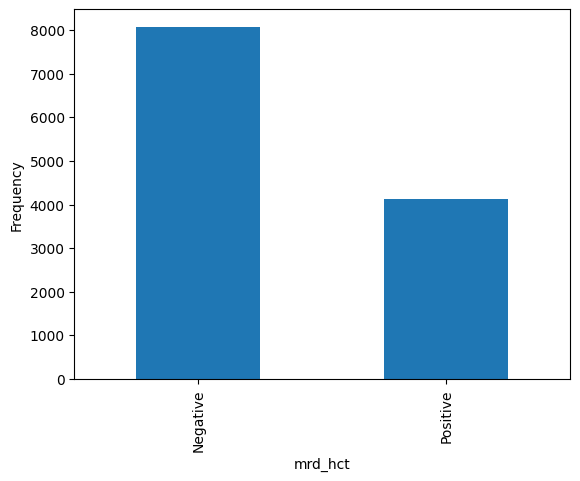

Column: in_vivo_tcd
Value Counts:
in_vivo_tcd
No     17591
Yes    10984
Name: count, dtype: int64
Bar plot:


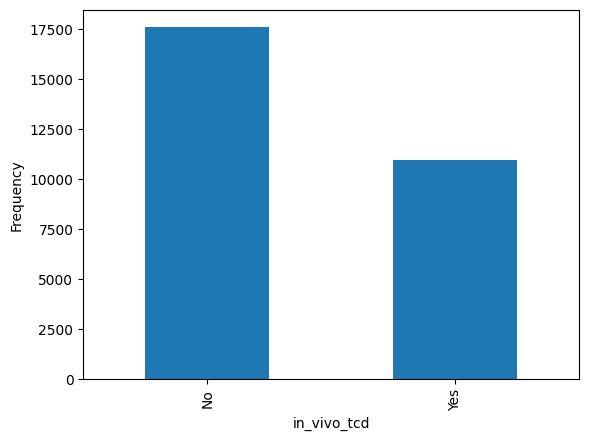

Column: tce_match
Value Counts:
tce_match
Permissive            6272
GvH non-permissive    1605
Fully matched         1059
HvG non-permissive     868
Name: count, dtype: int64
Bar plot:


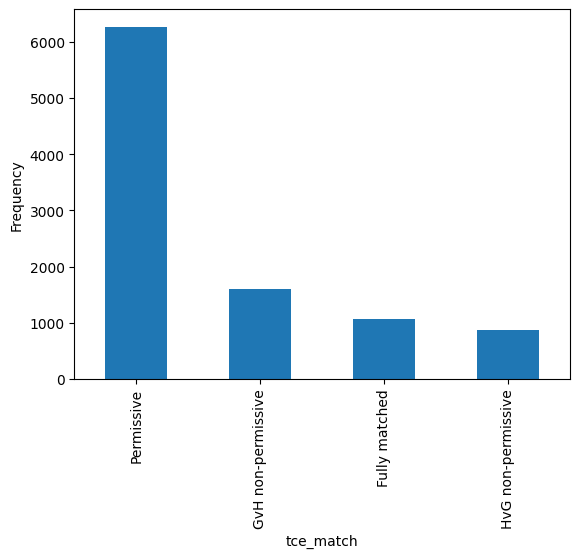

Column: hepatic_severe
Value Counts:
hepatic_severe
No          25238
Yes          1481
Not done      210
Name: count, dtype: int64
Bar plot:


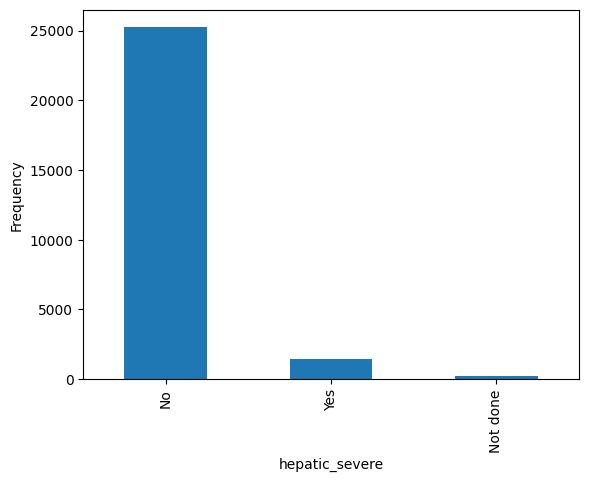

Column: prior_tumor
Value Counts:
prior_tumor
No          23828
Yes          3009
Not done      285
Name: count, dtype: int64
Bar plot:


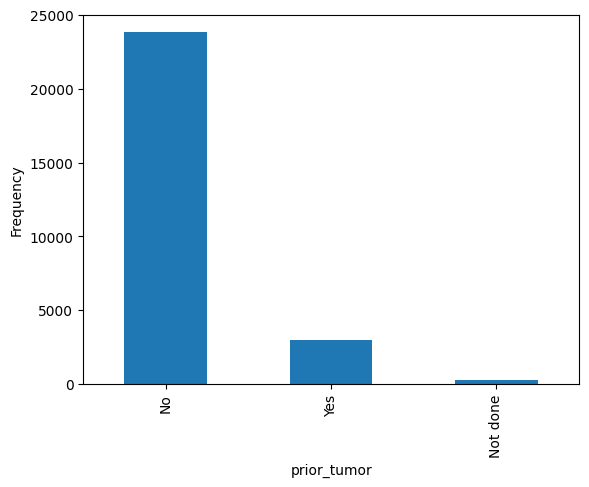

Column: peptic_ulcer
Value Counts:
peptic_ulcer
No          25956
Yes           259
Not done      166
Name: count, dtype: int64
Bar plot:


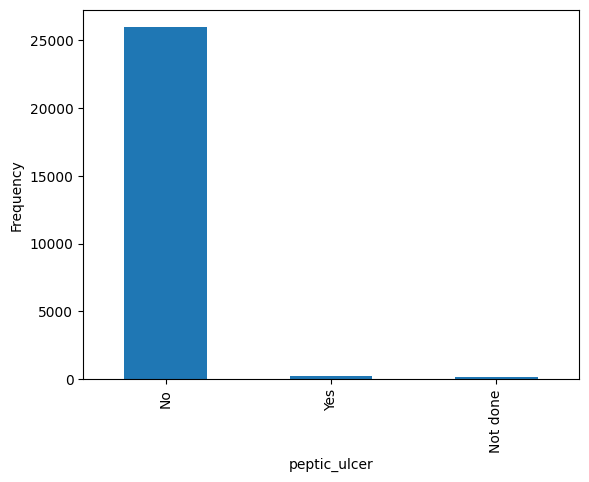

Column: gvhd_proph
Value Counts:
gvhd_proph
FK+ MMF +- others                  10440
Cyclophosphamide alone              5270
FK+ MTX +- others(not MMF)          4262
Cyclophosphamide +- others          2369
CSA + MMF +- others(not FK)         2278
FKalone                             1230
Other GVHD Prophylaxis               550
TDEPLETION alone                     545
TDEPLETION +- other                  539
No GvHD Prophylaxis                  262
CDselect alone                       251
CSA + MTX +- others(not MMF,FK)      224
CSA alone                            214
Parent Q = yes, but no agent          62
CDselect +- other                     55
CSA +- others(not FK,MMF,MTX)         23
FK+- others(not MMF,MTX)               1
Name: count, dtype: int64
Bar plot:


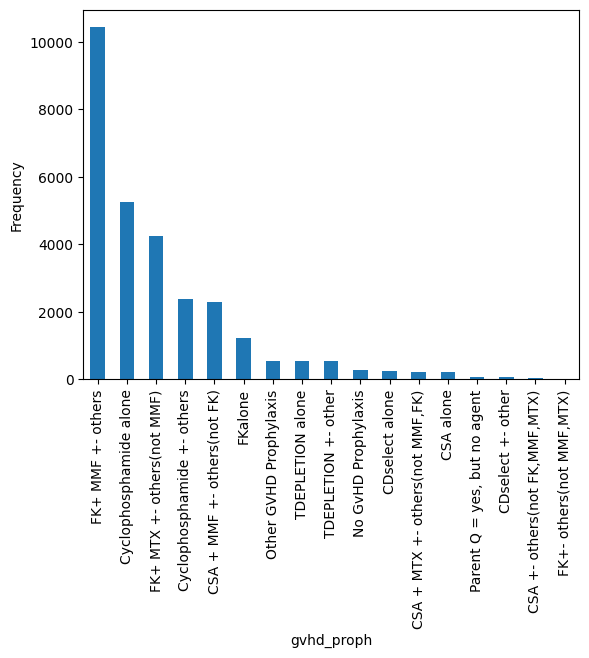

Column: rheum_issue
Value Counts:
rheum_issue
No          26015
Yes           457
Not done      145
Name: count, dtype: int64
Bar plot:


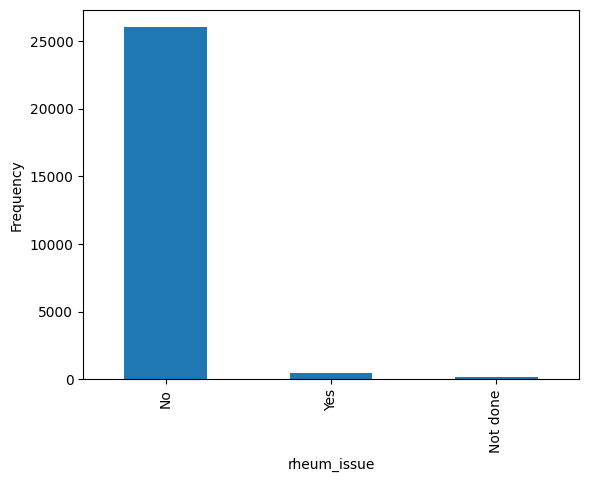

Column: sex_match
Value Counts:
sex_match
M-M    7980
F-M    7822
M-F    6715
F-F    6022
Name: count, dtype: int64
Bar plot:


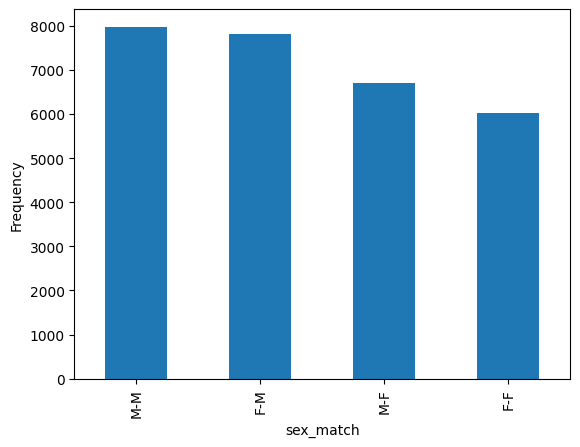

Column: race_group
Value Counts:
race_group
More than one race                           4845
Asian                                        4832
White                                        4831
Black or African-American                    4795
American Indian or Alaska Native             4790
Native Hawaiian or other Pacific Islander    4707
Name: count, dtype: int64
Bar plot:


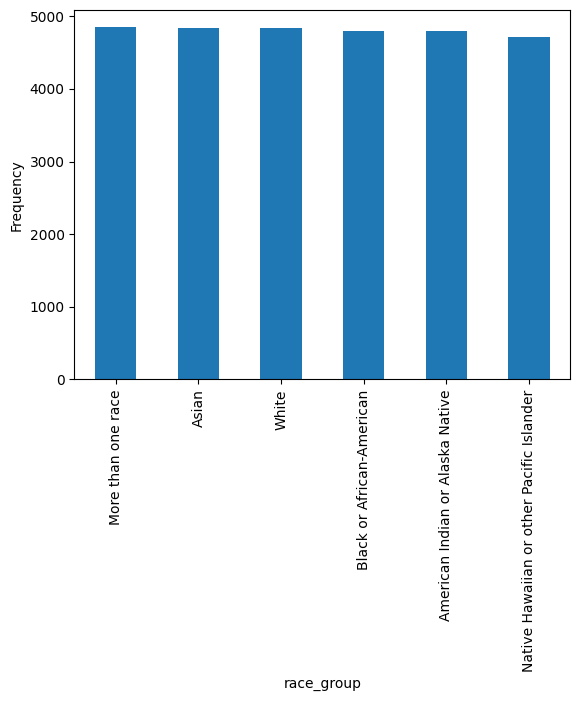

Column: hepatic_mild
Value Counts:
hepatic_mild
No          24989
Yes          1754
Not done      140
Name: count, dtype: int64
Bar plot:


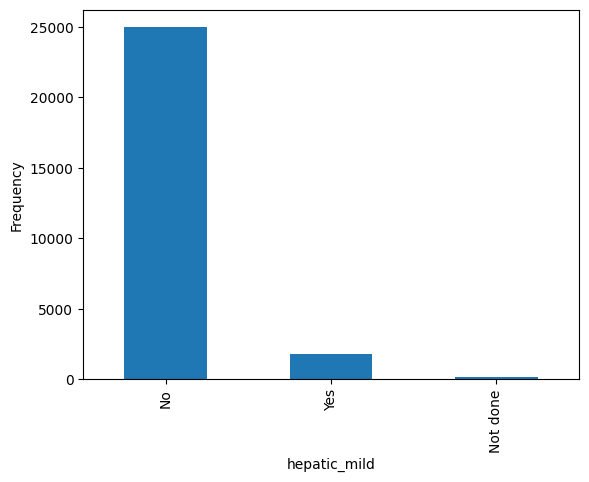

Column: tce_div_match
Value Counts:
tce_div_match
Permissive mismatched            12936
GvH non-permissive                2458
HvG non-permissive                1417
Bi-directional non-permissive      593
Name: count, dtype: int64
Bar plot:


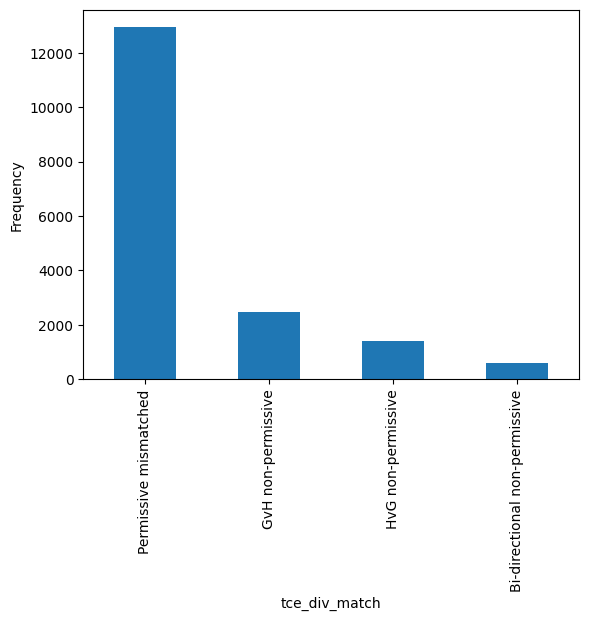

Column: donor_related
Value Counts:
donor_related
Related                     16208
Unrelated                   12088
Multiple donor (non-UCB)      346
Name: count, dtype: int64
Bar plot:


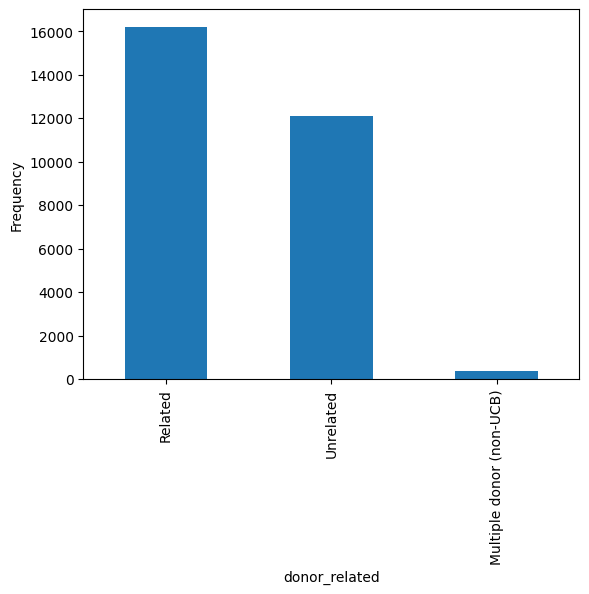

Column: melphalan_dose
Value Counts:
melphalan_dose
N/A, Mel not given    20135
MEL                    7260
Name: count, dtype: int64
Bar plot:


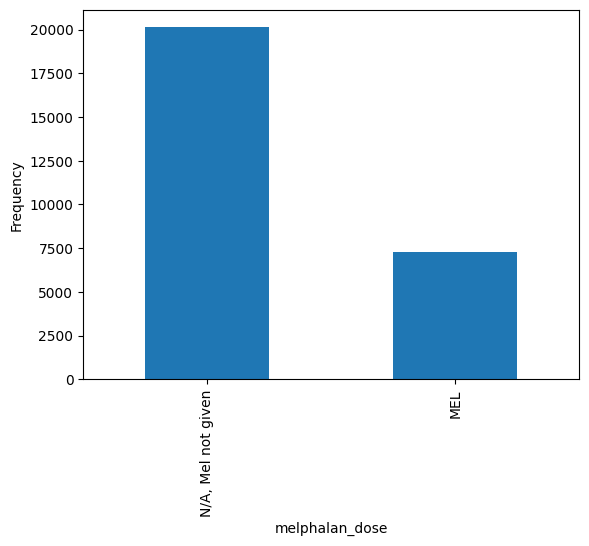

Column: cardiac
Value Counts:
cardiac
No          24592
Yes          1519
Not done      147
Name: count, dtype: int64
Bar plot:


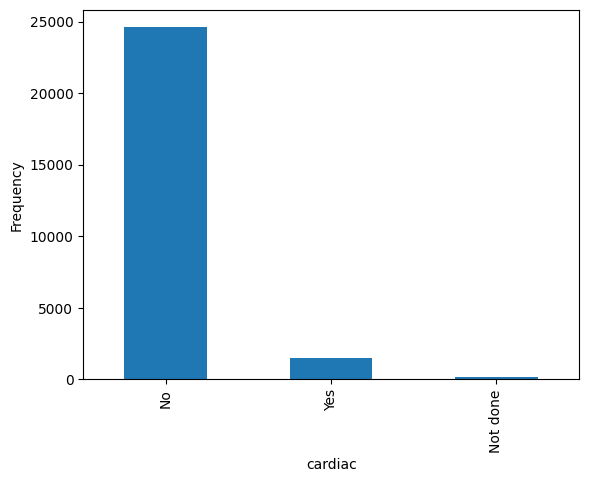

Column: pulm_moderate
Value Counts:
pulm_moderate
No          21338
Yes          5249
Not done      166
Name: count, dtype: int64
Bar plot:


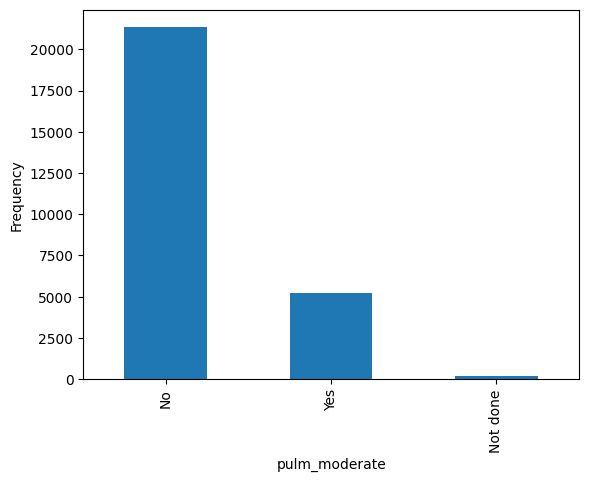

In [23]:
# Univariate analysis for categorical columns
for col in cat_cols:
    print("Column:", col)
    print("Value Counts:")
    print(data[col].value_counts())
    print("Bar plot:")
    data[col].value_counts().plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


After doing exploratory data analysis, we understood that all the feature with float datatype are skewed. Since the data distribution of float columns are skewed we will handle null values of numerical data with median imputation.
We also need to perform scaling since there is a high variance in dataset.

## Handling Missing Values

In [24]:
def impute_missing_data(data):
    # -------- Categorical Columns --------
    # 1. Impute with Mode
    mod_col_nam = ["graft_type", "prod_type", "race_group", "tbi_status", "prim_disease_hct"]
    for col in mod_col_nam:
        if col in data.columns:
            mode_val = data[col].mode().iloc[0] if not data[col].mode().empty else "Unknown"
            data[col] = data[col].fillna(mode_val)

    # 2. Impute with "Unknown"
    unknown_col_name = [
        "cmv_status", "conditioning_intensity", "ethnicity", "in_vivo_tcd", "dri_score",
        "gvhd_proph", "sex_match", "donor_related", "melphalan_dose", "mrd_hct",
        "cyto_score", "tce_imm_match", "cyto_score_detail", "tce_match", "tce_div_match"
    ]
    for col in unknown_col_name:
        if col in data.columns:
            data[col] = data[col].fillna("Unknown")

    # 3. Impute with "Not done"
    not_done_col_name = [
        "psych_disturb", "diabetes", "arrhythmia", "vent_hist", "renal_issue",
        "pulm_severe", "rituximab", "obesity", "hepatic_severe", "prior_tumor",
        "peptic_ulcer", "rheum_issue", "hepatic_mild", "cardiac", "pulm_moderate"
    ]
    for col in not_done_col_name:
        if col in data.columns:
            data[col] = data[col].fillna("Not done")

    # -------- Numerical Columns --------
    # 5. Impute with Median
    med_col_nam = [
        'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',
        'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low',
        'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'donor_age',
        'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score',
        'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'age_at_hct'
    ]
    for col in med_col_nam:
        if col in data.columns:
            median_val = data[col].median()
            data[col] = data[col].fillna(median_val)

    # 6. Impute Year of HCT with Mode (Discrete Numerical)
    if "year_hct" in data.columns:
        mode_year = data["year_hct"].mode()[0]
        data["year_hct"] = data["year_hct"].fillna(mode_year)

    return data


## Data Preprocessing

Here we will perform

- Feature Selection
- Missing Data Imputation
- Scaling Numerical Features
- Label Encoding Categorical Features

In [25]:
def preprocess_data(data, is_train=True):
    """
    Preprocesses the dataset by handling missing values, encoding categorical features,
    and dropping unnecessary columns.
    
    Parameters:
    data (pd.DataFrame): Input dataset.
    is_train (bool): Flag indicating whether the dataset is training data.
    
    Returns:
    pd.DataFrame: Preprocessed dataset.
    pd.Series (only for test data): Stored ID column for later use.
    """

    # Drop low-impact features
    data = data.drop(columns=[col for col in LOW_IMPACT_FEATURES if col in data.columns], errors="ignore")
    
    # Handle missing values
    data = impute_missing_data(data)
    
    # Store ID for test data and drop unnecessary columns
    if is_train==False:
        data = data.drop(columns=['efs', 'efs_time'], errors='ignore')

    # Identifying numerical features
    numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
    
    # Scaling numerical features
    scaler = StandardScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])
    
    # Encode categorical values
    label_encoders = {}
    for col in CATS:
        if col in data.columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    
    return data

In [26]:
train = preprocess_data(data)  # For training data
test = preprocess_data(test_data, is_train=False)  # For test data

<Axes: >

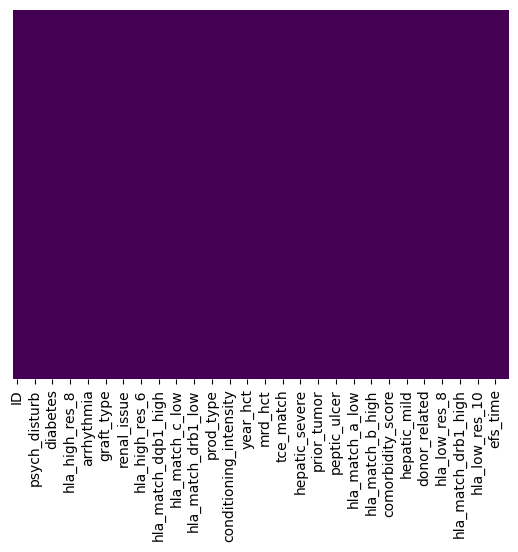

In [27]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<Axes: >

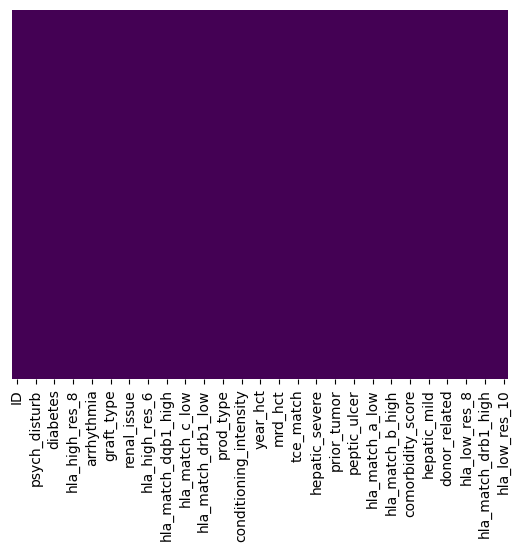

In [28]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [29]:
print(train.columns.tolist())

['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'prim_disease_hct', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'rheum_issue', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'efs', 'efs_time', 'y']


In [30]:
print(test.columns.tolist())

['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'prim_disease_hct', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'rheum_issue', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


# Feature Engineering

In [31]:
def features_engineering(df):
    # Change year_hct to relative year from 2000
    df['year_hct'] -= 2000
    df["age_dri_interaction"] = df["dri_score"] * np.log1p(df["age_at_hct"])

    scaler_fe = StandardScaler()
    df["karnofsky_score_scaled"] = scaler_fe.fit_transform(df[["karnofsky_score"]])

    return df

In [32]:
train = features_engineering(train)  # For training data
test = features_engineering(test)  # For test data

# Model Training and Evaluation

Here I used the XGB and CatBoost from [this notebook.](https://www.kaggle.com/code/kendontcare11/public-classifier-cat-xgb-lb-0-688/notebook)

## XGB

In [33]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

In [34]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
# from xgbse import XGBSEDebiasedBCE
import xgboost as xgb
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [35]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda", 
        enable_categorical=True
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.97561
[99]	validation_0-rmse:0.91509
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.95101
[99]	validation_0-rmse:0.89846
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.97040
[99]	validation_0-rmse:0.90133
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.98449
[99]	validation_0-rmse:0.92167
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.95368
[99]	validation_0-rmse:0.89896
#########################
### Fold 6
#########################
[0]	validation_0-rmse:0.97280
[99]	validation_0-rmse:0.92129
#########################
### Fold 7
#########################
[0]	validation_0-rmse:0.97836
[99]	validation_0-rmse:0.92673
#########################
### Fold 8
#########################
[0]	validation_0-rmse:0.95795
[99]	validation_0-rmse:0.91129
########

In [36]:
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)


Overall CV for XGBoost KaplanMeier = 0.6174806170551901


In [37]:
# import shap

# explainer = shap.Explainer(model_xgb, train[FEATURES])
# shap_values = explainer(train[FEATURES])

# shap.summary_plot(shap_values, train[FEATURES])


## CatBoostRegressor

In [38]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [39]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
        learning_rate=0.1,    
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS


#########################
### Fold 1
#########################
0:	learn: 0.9866918	test: 0.9961571	best: 0.9961571 (0)	total: 110ms	remaining: 1m 50s
250:	learn: 0.8298340	test: 0.8983416	best: 0.8983416 (250)	total: 4.8s	remaining: 14.3s
500:	learn: 0.7875179	test: 0.8972373	best: 0.8963395 (464)	total: 9.99s	remaining: 9.95s
750:	learn: 0.7510270	test: 0.8971865	best: 0.8963395 (464)	total: 15.1s	remaining: 4.99s
999:	learn: 0.7207892	test: 0.9001437	best: 0.8963395 (464)	total: 20s	remaining: 0us
bestTest = 0.896339451
bestIteration = 464
Shrink model to first 465 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.9896408	test: 0.9719929	best: 0.9719929 (0)	total: 20.6ms	remaining: 20.6s
250:	learn: 0.8308117	test: 0.8812078	best: 0.8810758 (237)	total: 4.88s	remaining: 14.6s
500:	learn: 0.7884853	test: 0.8808692	best: 0.8805122 (388)	total: 9.96s	remaining: 9.92s
750:	learn: 0.7531042	test: 0.8829237	best: 0.8805122 (388)	total: 15.2s	remaining: 

In [40]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m)


Overall CV for CatBoost KaplanMeier = 0.6308638666291555


## NNModel

Standard Neural Network (NN) with KFold validation using PyTorch

- Input layer: Matching feature dimensions
- Hidden layers: Fully connected layers with ReLU activation, batch normalization, and dropout
- Output layer: Single neuron (regression output)
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam
- KFold Cross-Validation: Ensuring consistency with your structure

In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to tensors
def prepare_data(df, feature_cols, target_col):
    X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    y = torch.tensor(df[target_col].values, dtype=torch.float32).view(-1, 1)
    return X, y

# Define NN Model
class NNModel(nn.Module):
    def __init__(self, input_dim):
        super(NNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Regression output
        )
    
    def forward(self, x):
        return self.model(x)

# KFold Cross Validation
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_nn = np.zeros(len(train))
pred_nn = np.zeros(len(test))

TARGET = "y"

X_train, y_train = prepare_data(train, FEATURES, TARGET)
X_test, _ = prepare_data(test, FEATURES, TARGET)

for i, (train_index, val_index) in enumerate(kf.split(train)):
    print(f"\n### Fold {i+1} ###")
    
    # Prepare datasets
    X_tr, y_tr = X_train[train_index], y_train[train_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    
    train_ds = TensorDataset(X_tr, y_tr)
    val_ds = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
    
    # Model
    model = NNModel(input_dim=len(FEATURES)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Training
    for epoch in range(100):  # Adjust epochs if necessary
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    val_preds = []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            val_preds.extend(preds)
    
    oof_nn[val_index] = np.array(val_preds).flatten()
    
    # Predict test data
    test_preds = model(X_test.to(device)).cpu().detach().numpy().flatten()
    pred_nn += test_preds

# Compute average test predictions
pred_nn /= FOLDS

# Evaluate
y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_nn
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Neural Network = {m}")


Using device: cuda

### Fold 1 ###

### Fold 2 ###

### Fold 3 ###

### Fold 4 ###

### Fold 5 ###

### Fold 6 ###

### Fold 7 ###

### Fold 8 ###

### Fold 9 ###

### Fold 10 ###

Overall CV for Neural Network = 0.49808809762698036


## Ensemble

In [42]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_nn)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6131807558773943


In [43]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_xgb) + rankdata(pred_cat) + rankdata(pred_nn)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,3.0
1,28801,8.0
2,28802,7.0
